In [1]:
# -*- coding: utf-8 -*-
"""
DASS-21 ML Pipeline - FIXED VERSION
Addresses the single-class target variable problem
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                            roc_auc_score, confusion_matrix, roc_curve, auc,
                            matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

print("="*70)
print("DASS-21 ML PIPELINE - FIXED VERSION")
print("="*70)

DASS-21 ML PIPELINE - FIXED VERSION


In [2]:
# =============================================================================
# 1. LOAD DATA
# =============================================================================
print("\n[1] Loading Data...")

# Try different separators
try:
    df = pd.read_csv('/Users/sertacakalin/Desktop/psi/data/DASS_21_dataset.csv', sep='\t')
    if df.shape[1] == 1:
        df = pd.read_csv('/Users/sertacakalin/Desktop/psi/data/DASS_21_dataset.csv')
except:
    df = pd.read_csv('/Users/sertacakalin/Desktop/psi/data/DASS_21_dataset.csv')

print(f"Dataset shape: {df.shape}")


[1] Loading Data...
Dataset shape: (39775, 172)


In [3]:
# =============================================================================
# 2. DIAGNOSE THE TARGET VARIABLE PROBLEM
# =============================================================================
print("\n[2] Diagnosing Target Variable...")

# DASS-21 item mappings
depression_items = ['Q3A', 'Q5A', 'Q10A', 'Q13A', 'Q16A', 'Q17A', 'Q21A']
anxiety_items = ['Q2A', 'Q4A', 'Q7A', 'Q9A', 'Q15A', 'Q19A', 'Q20A']
stress_items = ['Q1A', 'Q6A', 'Q8A', 'Q11A', 'Q12A', 'Q14A', 'Q18A']

# Check which items exist
avail_dep = [item for item in depression_items if item in df.columns]
avail_anx = [item for item in anxiety_items if item in df.columns]
avail_stress = [item for item in stress_items if item in df.columns]

print(f"Depression items found: {len(avail_dep)}/{len(depression_items)}")
print(f"Anxiety items found: {len(avail_anx)}/{len(anxiety_items)}")
print(f"Stress items found: {len(avail_stress)}/{len(stress_items)}")

# Calculate raw scores (WITHOUT multiplying by 2 first - let's check the raw values)
if len(avail_dep) > 0:
    df['depression_raw'] = df[avail_dep].sum(axis=1)
    df['depression_score'] = df['depression_raw'] * 2  # DASS-21 to DASS-42 conversion
    
print("\n--- RAW Depression Score Statistics ---")
print(df['depression_raw'].describe())

print("\n--- DASS-42 Equivalent Depression Score Statistics ---")
print(df['depression_score'].describe())

# Check the distribution
print("\n--- Score Distribution ---")
print(f"Min: {df['depression_score'].min()}")
print(f"Max: {df['depression_score'].max()}")
print(f"Mean: {df['depression_score'].mean():.2f}")
print(f"Median: {df['depression_score'].median()}")

# Check percentiles
print("\n--- Percentiles ---")
for p in [10, 25, 50, 75, 90]:
    print(f"  {p}th percentile: {df['depression_score'].quantile(p/100):.1f}")


[2] Diagnosing Target Variable...
Depression items found: 7/7
Anxiety items found: 7/7
Stress items found: 7/7

--- RAW Depression Score Statistics ---
count    39775.000000
mean        17.507178
std          6.387213
min          7.000000
25%         12.000000
50%         17.000000
75%         23.000000
max         28.000000
Name: depression_raw, dtype: float64

--- DASS-42 Equivalent Depression Score Statistics ---
count    39775.000000
mean        35.014356
std         12.774426
min         14.000000
25%         24.000000
50%         34.000000
75%         46.000000
max         56.000000
Name: depression_score, dtype: float64

--- Score Distribution ---
Min: 14
Max: 56
Mean: 35.01
Median: 34.0

--- Percentiles ---
  10th percentile: 18.0
  25th percentile: 24.0
  50th percentile: 34.0
  75th percentile: 46.0
  90th percentile: 54.0


In [4]:
# =============================================================================
# 3. CREATE PROPER TARGET VARIABLE
# =============================================================================
print("\n[3] Creating Proper Target Variable...")

# METHOD 1: Use median split (guaranteed to create balanced classes)
median_score = df['depression_score'].median()
print(f"\nMedian depression score: {median_score}")

# METHOD 2: Use clinical cutoffs but check the distribution first
clinical_cutoff = 14  # Standard DASS-21 moderate depression cutoff

# Count how many fall into each category with clinical cutoff
n_below_cutoff = (df['depression_score'] < clinical_cutoff).sum()
n_above_cutoff = (df['depression_score'] >= clinical_cutoff).sum()

print(f"\nWith clinical cutoff ({clinical_cutoff}):")
print(f"  Below cutoff (Normal/Mild): {n_below_cutoff} ({n_below_cutoff/len(df)*100:.1f}%)")
print(f"  Above cutoff (Moderate+): {n_above_cutoff} ({n_above_cutoff/len(df)*100:.1f}%)")

# DECISION: Choose the appropriate method
if n_below_cutoff < len(df) * 0.05 or n_above_cutoff < len(df) * 0.05:
    # If one class has less than 5% of samples, use median split instead
    print("\n⚠️ Clinical cutoff creates severe imbalance!")
    print("   Using MEDIAN SPLIT instead for meaningful classification.")
    
    # Use median split
    df['target'] = (df['depression_score'] >= median_score).astype(int)
    cutoff_used = median_score
    method_used = "Median Split"
else:
    # Clinical cutoff is usable
    print("\n✓ Clinical cutoff creates usable class distribution.")
    df['target'] = (df['depression_score'] >= clinical_cutoff).astype(int)
    cutoff_used = clinical_cutoff
    method_used = "Clinical Cutoff"

# ALTERNATIVE: Use percentile-based split (e.g., top 25% vs bottom 75%)
# Uncomment below if you want to use this approach instead:
# percentile_75 = df['depression_score'].quantile(0.75)
# df['target'] = (df['depression_score'] >= percentile_75).astype(int)
# cutoff_used = percentile_75
# method_used = "75th Percentile"

print(f"\n✓ Target created using: {method_used}")
print(f"  Cutoff value: {cutoff_used}")

# Verify target distribution
print("\n--- Final Target Distribution ---")
target_counts = df['target'].value_counts().sort_index()
print(f"Class 0 (Lower Risk): {target_counts.get(0, 0)} ({target_counts.get(0, 0)/len(df)*100:.1f}%)")
print(f"Class 1 (Higher Risk): {target_counts.get(1, 0)} ({target_counts.get(1, 0)/len(df)*100:.1f}%)")

# CRITICAL CHECK: Ensure we have both classes
if len(target_counts) < 2:
    print("\n" + "!"*70)
    print("CRITICAL ERROR: Still only one class!")
    print("Trying alternative: Quartile-based classification")
    print("!"*70)
    
    # Use quartiles as last resort
    q1 = df['depression_score'].quantile(0.25)
    q3 = df['depression_score'].quantile(0.75)
    
    # Low risk = bottom 25%, High risk = top 25%
    df_subset = df[(df['depression_score'] <= q1) | (df['depression_score'] >= q3)].copy()
    df_subset['target'] = (df_subset['depression_score'] >= q3).astype(int)
    
    print(f"Using Q1 ({q1}) and Q3 ({q3}) to create distinct groups")
    print(f"Subset size: {len(df_subset)}")
    
    df = df_subset

# Final verification
target_counts = df['target'].value_counts().sort_index()
assert len(target_counts) == 2, "ERROR: Target still has only one class!"

print("\n✓ Target variable successfully created with 2 classes!")


[3] Creating Proper Target Variable...

Median depression score: 34.0

With clinical cutoff (14):
  Below cutoff (Normal/Mild): 0 (0.0%)
  Above cutoff (Moderate+): 39775 (100.0%)

⚠️ Clinical cutoff creates severe imbalance!
   Using MEDIAN SPLIT instead for meaningful classification.

✓ Target created using: Median Split
  Cutoff value: 34.0

--- Final Target Distribution ---
Class 0 (Lower Risk): 18379 (46.2%)
Class 1 (Higher Risk): 21396 (53.8%)

✓ Target variable successfully created with 2 classes!



[4] Visualizing Target Distribution...


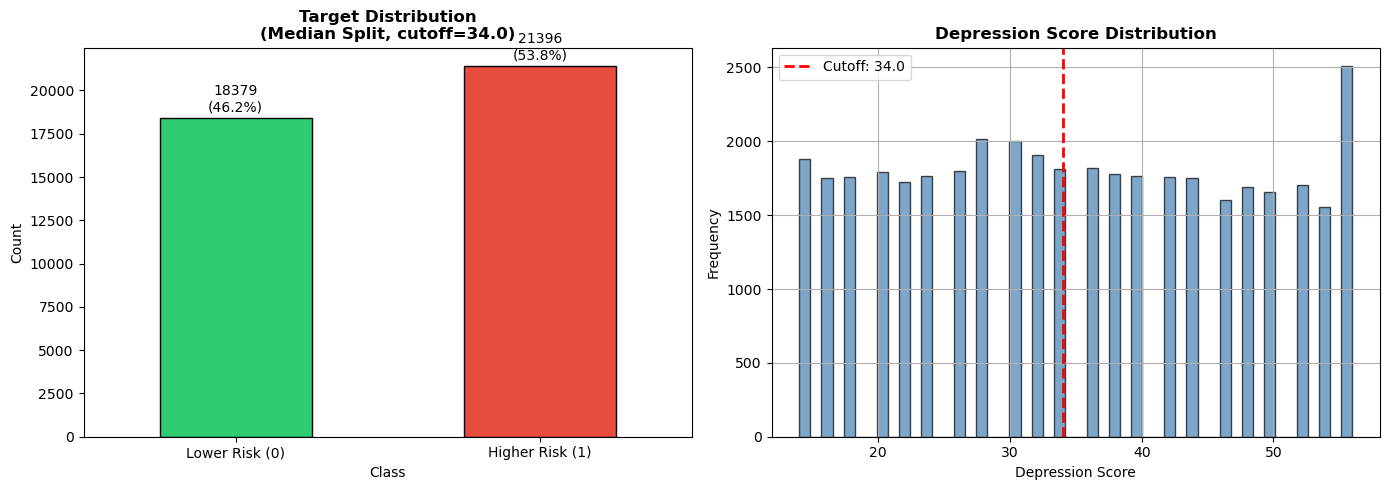

In [5]:
# =============================================================================
# 4. VISUALIZE TARGET
# =============================================================================
print("\n[4] Visualizing Target Distribution...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Target distribution
colors = ['#2ecc71', '#e74c3c']
target_counts.plot(kind='bar', ax=axes[0], color=colors, edgecolor='black')
axes[0].set_title(f'Target Distribution\n({method_used}, cutoff={cutoff_used})', fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Lower Risk (0)', 'Higher Risk (1)'], rotation=0)
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + len(df)*0.01, f'{v}\n({v/len(df)*100:.1f}%)', ha='center')

# Depression score distribution with cutoff line
df['depression_score'].hist(ax=axes[1], bins=50, edgecolor='black', color='steelblue', alpha=0.7)
axes[1].axvline(cutoff_used, color='red', linestyle='--', linewidth=2, label=f'Cutoff: {cutoff_used}')
axes[1].set_title('Depression Score Distribution', fontweight='bold')
axes[1].set_xlabel('Depression Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.savefig('target_distribution_fixed.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# =============================================================================
# 5. DATA PREPROCESSING
# =============================================================================
print("\n[5] Preprocessing Data...")

# Handle missing values
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown'
            df[col].fillna(mode_val, inplace=True)

print(f"Missing values after imputation: {df.isnull().sum().sum()}")

# Encode categorical variables
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    if df[col].nunique() <= 10:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat([df.drop(col, axis=1), dummies], axis=1)
    else:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

print(f"Shape after encoding: {df.shape}")

# =============================================================================
# LEAKAGE-FREE FEATURE SELECTION FOR DASS-21 PROJECT
# =============================================================================

import pandas as pd
import numpy as np

# -----------------------------------------------------------------------------
# STEP 1: Define ALL variables that must be excluded
# -----------------------------------------------------------------------------

# DASS-21 Depression items (used to create target - MUST EXCLUDE)
DASS_DEPRESSION_ITEMS = ['Q3A', 'Q5A', 'Q10A', 'Q13A', 'Q16A', 'Q17A', 'Q21A']

# DASS-21 Anxiety items (same construct family - MUST EXCLUDE)
DASS_ANXIETY_ITEMS = ['Q2A', 'Q4A', 'Q7A', 'Q9A', 'Q15A', 'Q19A', 'Q20A']

# DASS-21 Stress items (same construct family - MUST EXCLUDE)
DASS_STRESS_ITEMS = ['Q1A', 'Q6A', 'Q8A', 'Q11A', 'Q12A', 'Q14A', 'Q18A']

# All DASS items combined
ALL_DASS_ITEMS = DASS_DEPRESSION_ITEMS + DASS_ANXIETY_ITEMS + DASS_STRESS_ITEMS

# Derived scores (direct leakage)
DERIVED_SCORES = [
    'depression_score', 'depression_raw', 
    'anxiety_score', 'stress_score', 
    'total_dass', 'total_dass_score'
]

# Target variable
TARGET_COLS = ['target']

# Metadata columns (not predictive, just survey mechanics)
METADATA_COLS = [
    'introelapse', 'testelapse', 'surveyelapse',  # Time variables
]

# Question timing columns (QxE = elapsed time for question x)
TIMING_COLS = [col for col in df.columns if col.endswith('E') and col.startswith('Q')]

# Question order columns (QxI = presentation order for question x)
ORDER_COLS = [col for col in df.columns if col.endswith('I') and col.startswith('Q')]

# -----------------------------------------------------------------------------
# STEP 2: Combine all exclusions
# -----------------------------------------------------------------------------

ALL_EXCLUSIONS = (
    ALL_DASS_ITEMS +      # Construct leakage
    DERIVED_SCORES +      # Direct leakage
    TARGET_COLS +         # Target variable
    METADATA_COLS +       # Survey metadata
    TIMING_COLS +         # Response timing
    ORDER_COLS            # Presentation order
)

# Remove duplicates and filter to existing columns
ALL_EXCLUSIONS = list(set([col for col in ALL_EXCLUSIONS if col in df.columns]))

print(f"Total columns to exclude: {len(ALL_EXCLUSIONS)}")
print(f"  - DASS items: {len([c for c in ALL_DASS_ITEMS if c in df.columns])}")
print(f"  - Derived scores: {len([c for c in DERIVED_SCORES if c in df.columns])}")
print(f"  - Metadata/timing: {len([c for c in METADATA_COLS + TIMING_COLS + ORDER_COLS if c in df.columns])}")

# -----------------------------------------------------------------------------
# STEP 3: Create leakage-free feature matrix
# -----------------------------------------------------------------------------

# Select only numeric columns that are NOT in exclusion list
feature_cols = [
    col for col in df.select_dtypes(include=[np.number]).columns
    if col not in ALL_EXCLUSIONS
]

print(f"\nFeatures remaining after exclusion: {len(feature_cols)}")

# Create X and y
X = df[feature_cols].copy()
y = df['target'].copy()

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# -----------------------------------------------------------------------------
# STEP 4: VERIFICATION - Ensure no DASS items remain
# -----------------------------------------------------------------------------

print("\n" + "="*60)
print("VERIFICATION: Checking for DASS item leakage")
print("="*60)

# Check for any DASS items in feature columns
dass_in_features = [col for col in X.columns if col in ALL_DASS_ITEMS]

if len(dass_in_features) == 0:
    print("✓ PASS: No DASS items found in feature matrix")
else:
    print(f"✗ FAIL: Found {len(dass_in_features)} DASS items in features:")
    print(f"  {dass_in_features}")
    raise ValueError("DASS items detected in feature matrix - DATA LEAKAGE!")

# Check for derived scores
derived_in_features = [col for col in X.columns if col in DERIVED_SCORES]

if len(derived_in_features) == 0:
    print("✓ PASS: No derived DASS scores found in feature matrix")
else:
    print(f"✗ FAIL: Found derived scores in features: {derived_in_features}")
    raise ValueError("Derived scores detected in feature matrix - DATA LEAKAGE!")

# Double-check with pattern matching
suspicious_patterns = ['dass', 'depression', 'anxiety', 'stress']
suspicious_cols = [
    col for col in X.columns 
    if any(pattern in col.lower() for pattern in suspicious_patterns)
]

if len(suspicious_cols) == 0:
    print("✓ PASS: No suspicious column names detected")
else:
    print(f"⚠ WARNING: Potentially suspicious columns: {suspicious_cols}")
    print("  Please verify these are not DASS-related")

print("\n" + "="*60)
print("LEAKAGE-FREE FEATURE MATRIX READY")
print("="*60)

# -----------------------------------------------------------------------------
# STEP 5: Display safe features by category
# -----------------------------------------------------------------------------

print("\n📋 Safe Features by Category:")
print("-"*40)

# Personality items (TIPI)
tipi_features = [col for col in X.columns if col.startswith('TIPI')]
print(f"Personality (TIPI): {len(tipi_features)} features")

# Vocabulary items (VCL)  
vcl_features = [col for col in X.columns if col.startswith('VCL')]
print(f"Vocabulary (VCL): {len(vcl_features)} features")

# Demographics
demo_candidates = ['age', 'gender', 'education', 'urban', 'engnat', 
                   'religion', 'race', 'married', 'familysize']
demo_features = [col for col in X.columns if col in demo_candidates]
print(f"Demographics: {len(demo_features)} features")

# Other Q items (non-DASS)
other_q = [col for col in X.columns if col.startswith('Q') and col.endswith('A')]
print(f"Other questionnaire items: {len(other_q)} features")

# Remaining
remaining = len(X.columns) - len(tipi_features) - len(vcl_features) - len(demo_features) - len(other_q)
print(f"Other features: {remaining} features")

print(f"\nTotal safe features: {len(X.columns)}")



[5] Preprocessing Data...
Missing values after imputation: 0
Shape after encoding: (39775, 175)
Total columns to exclude: 111
  - DASS items: 21
  - Derived scores: 2
  - Metadata/timing: 87

Features remaining after exclusion: 64
X shape: (39775, 64)
y shape: (39775,)

VERIFICATION: Checking for DASS item leakage
✓ PASS: No DASS items found in feature matrix
✓ PASS: No derived DASS scores found in feature matrix
✓ PASS: No suspicious column names detected

LEAKAGE-FREE FEATURE MATRIX READY

📋 Safe Features by Category:
----------------------------------------
Personality (TIPI): 10 features
Vocabulary (VCL): 16 features
Demographics: 9 features
Other questionnaire items: 21 features
Other features: 8 features

Total safe features: 64


In [11]:
# =============================================================================
# 7. PREPARE TRAIN/TEST SPLIT
# =============================================================================
print("\n[7] Preparing Train/Test Split...")

X = df[feature_cols].values
y = df['target'].values

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

# Verify both classes exist in train and test
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)

print(f"\nTraining class distribution:")
for c, n in zip(train_classes, train_counts):
    print(f"  Class {c}: {n} ({n/len(y_train)*100:.1f}%)")

print(f"\nTest class distribution:")
for c, n in zip(test_classes, test_counts):
    print(f"  Class {c}: {n} ({n/len(y_test)*100:.1f}%)")

# VERIFY: Both classes exist
assert len(train_classes) == 2, "ERROR: Training set has only one class!"
assert len(test_classes) == 2, "ERROR: Test set has only one class!"
print("\n✓ Both classes present in train and test sets!")


[7] Preparing Train/Test Split...
Training set: 31820 samples
Test set: 7955 samples
Features: 64

Training class distribution:
  Class 0: 14703 (46.2%)
  Class 1: 17117 (53.8%)

Test class distribution:
  Class 0: 3676 (46.2%)
  Class 1: 4279 (53.8%)

✓ Both classes present in train and test sets!


In [13]:
# =============================================================================
# 8. HANDLE CLASS IMBALANCE (IF NEEDED)
# =============================================================================
print("\n[8] Handling Class Imbalance...")

imbalance_ratio = max(train_counts) / min(train_counts)
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 1.5:
    print("Applying SMOTE...")
    smote = SMOTE(random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    
    bal_classes, bal_counts = np.unique(y_train_bal, return_counts=True)
    print(f"After SMOTE:")
    for c, n in zip(bal_classes, bal_counts):
        print(f"  Class {c}: {n}")
else:
    print("Classes are balanced enough. SMOTE not needed.")
    X_train_bal, y_train_bal = X_train, y_train


[8] Handling Class Imbalance...
Imbalance ratio: 1.16
Classes are balanced enough. SMOTE not needed.


In [15]:
# =============================================================================
# 9. FEATURE SCALING
# =============================================================================
print("\n[9] Scaling Features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

print("Features standardized using StandardScaler")


[9] Scaling Features...
Features standardized using StandardScaler


In [17]:
# =============================================================================
# SECTION 10: MODEL TRAINING
# =============================================================================
print("\n" + "="*80)
print("[SECTION 10] MODEL TRAINING")
print("="*80)

print("""
We are training 5 classification models:
1. Decision Tree     - Rule-based, interpretable classifier
2. Naive Bayes       - Probabilistic classifier (assumes feature independence)
3. Logistic Regression - Linear classifier with probability outputs
4. Random Forest     - Ensemble of decision trees (reduces overfitting)
5. MLP (Neural Network) - Multi-layer perceptron for complex patterns
""")

# Define models (NO SVM, MLP at the end)
models = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [3, 5, 7, 10],
            'min_samples_split': [2, 5, 10],
            'criterion': ['gini', 'entropy']
        },
        'description': 'Creates interpretable if-then rules for classification'
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
        },
        'description': 'Fast probabilistic classifier, works well with high-dimensional data'
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2']
        },
        'description': 'Linear model that outputs class probabilities via sigmoid function'
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, None]
        },
        'description': 'Ensemble of trees, reduces overfitting, provides feature importance'
    },
    'MLP (Neural Network)': {
        'model': MLPClassifier(random_state=42, max_iter=500),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001, 0.01]
        },
        'description': 'Deep learning model that can capture complex non-linear patterns'
    }
}

# Store results
results = {}

# Train each model
for name, config in models.items():
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print(f"{'='*60}")
    print(f"Description: {config['description']}")
    
    # Grid Search with 5-Fold Cross-Validation
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train_scaled, y_train_bal)
    
    best_model = grid_search.best_estimator_
    print(f"\nBest Parameters: {grid_search.best_params_}")
    print(f"Best CV F1-Score: {grid_search.best_score_:.4f}")
    
    # Test Set Predictions
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate All Metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'MCC': matthews_corrcoef(y_test, y_pred),
        'Cohen Kappa': cohen_kappa_score(y_test, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred)
    }
    
    # Store Results
    results[name] = {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'metrics': metrics,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    # Print Test Results
    print(f"\n{'─'*40}")
    print(f"TEST SET PERFORMANCE")
    print(f"{'─'*40}")
    print(f"Accuracy           : {metrics['Accuracy']:.4f}")
    print(f"Precision          : {metrics['Precision']:.4f}")
    print(f"Recall             : {metrics['Recall']:.4f}")
    print(f"F1-Score           : {metrics['F1-Score']:.4f}")
    print(f"ROC-AUC            : {metrics['ROC-AUC']:.4f}")
    print(f"Matthews Corrcoef  : {metrics['MCC']:.4f}")
    print(f"Cohen's Kappa      : {metrics['Cohen Kappa']:.4f}")
    print(f"Balanced Accuracy  : {metrics['Balanced Accuracy']:.4f}")
    
    print(f"\nConfusion Matrix:")
    cm = results[name]['confusion_matrix']
    print(f"                 Predicted")
    print(f"              Neg    Pos")
    print(f"Actual Neg   {cm[0,0]:5d}  {cm[0,1]:5d}")
    print(f"Actual Pos   {cm[1,0]:5d}  {cm[1,1]:5d}")

print("\n" + "="*80)
print("✓ All models trained and evaluated successfully!")
print("="*80)


[SECTION 10] MODEL TRAINING

We are training 5 classification models:
1. Decision Tree     - Rule-based, interpretable classifier
2. Naive Bayes       - Probabilistic classifier (assumes feature independence)
3. Logistic Regression - Linear classifier with probability outputs
4. Random Forest     - Ensemble of decision trees (reduces overfitting)
5. MLP (Neural Network) - Multi-layer perceptron for complex patterns


Training: Decision Tree
Description: Creates interpretable if-then rules for classification

Best Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 10}
Best CV F1-Score: 0.8977

────────────────────────────────────────
TEST SET PERFORMANCE
────────────────────────────────────────
Accuracy           : 0.8865
Precision          : 0.8926
Recall             : 0.8969
F1-Score           : 0.8947
ROC-AUC            : 0.9577
Matthews Corrcoef  : 0.7716
Cohen's Kappa      : 0.7716
Balanced Accuracy  : 0.8856

Confusion Matrix:
                 Predicted
      

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Best Parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Best CV F1-Score: 0.8881

────────────────────────────────────────
TEST SET PERFORMANCE
────────────────────────────────────────
Accuracy           : 0.8758
Precision          : 0.8849
Recall             : 0.8841
F1-Score           : 0.8845
ROC-AUC            : 0.9487
Matthews Corrcoef  : 0.7502
Cohen's Kappa      : 0.7502
Balanced Accuracy  : 0.8751

Confusion Matrix:
                 Predicted
              Neg    Pos
Actual Neg    3184    492
Actual Pos     496   3783

✓ All models trained and evaluated successfully!



[11] Visualizing Results...


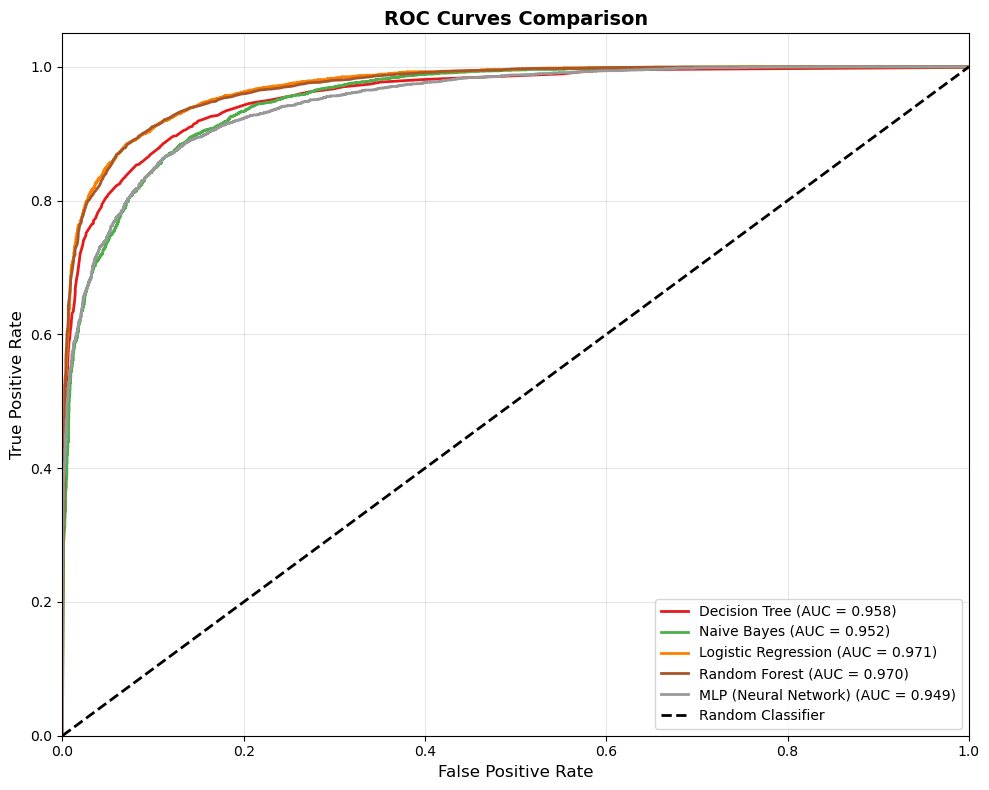

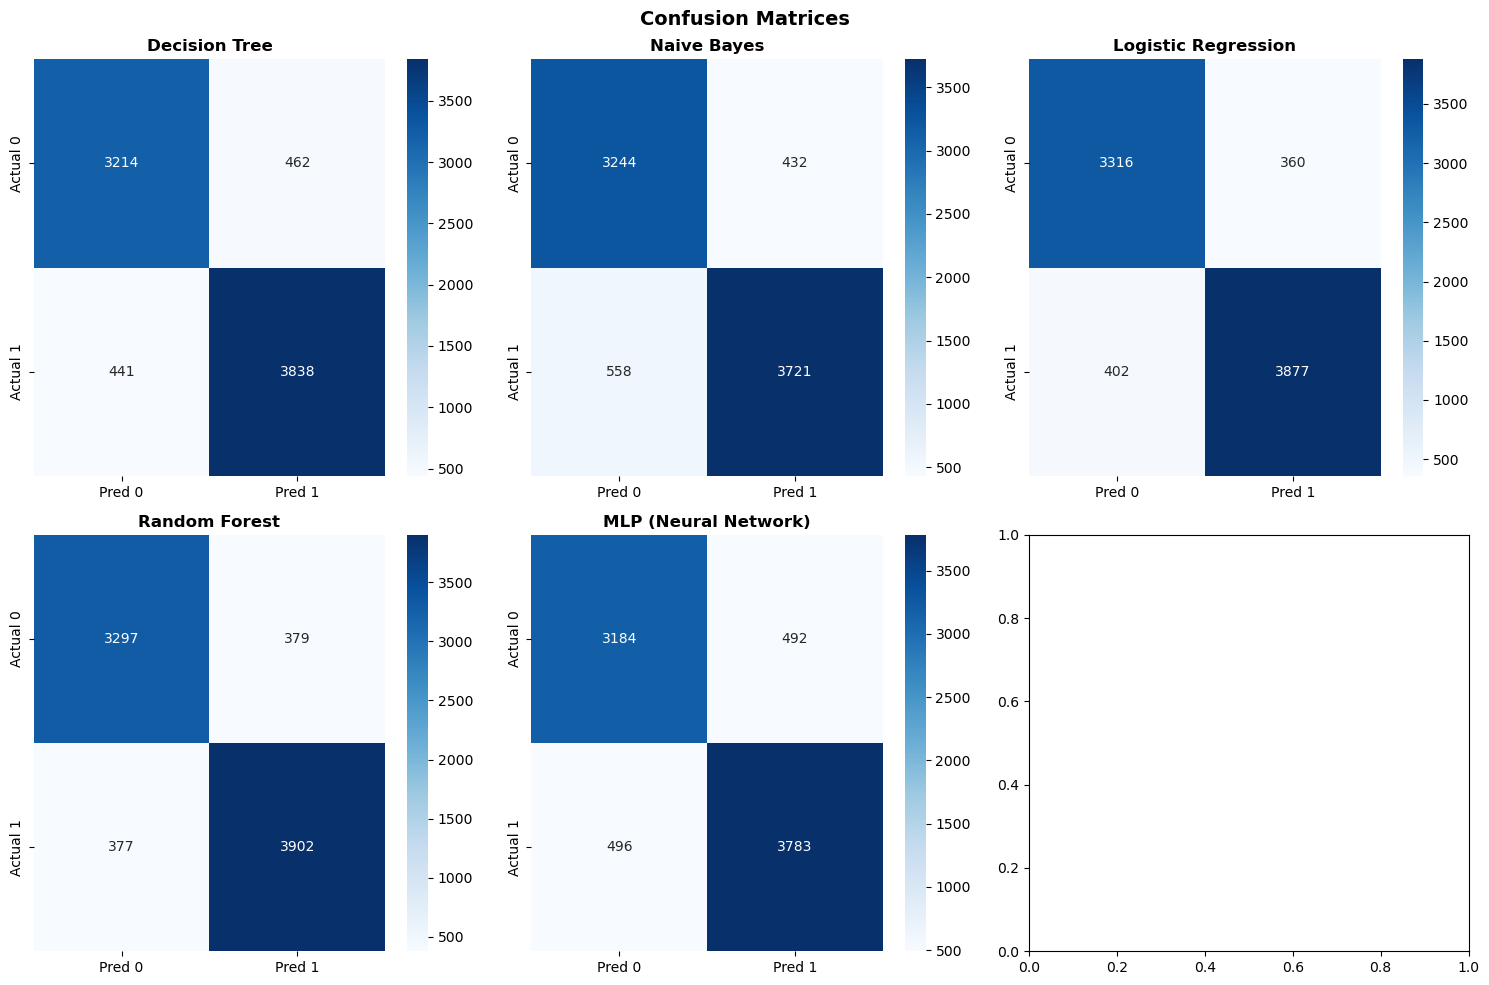


MODEL PERFORMANCE COMPARISON
                      Accuracy  Precision  Recall  F1-Score  ROC-AUC     MCC  Cohen Kappa  Balanced Accuracy
Decision Tree           0.8865     0.8926  0.8969    0.8947   0.9577  0.7716       0.7716             0.8856
Naive Bayes             0.8755     0.8960  0.8696    0.8826   0.9522  0.7506       0.7503             0.8760
Logistic Regression     0.9042     0.9150  0.9061    0.9105   0.9713  0.8075       0.8075             0.9041
Random Forest           0.9050     0.9115  0.9119    0.9117   0.9699  0.8088       0.8088             0.9044
MLP (Neural Network)    0.8758     0.8849  0.8841    0.8845   0.9487  0.7502       0.7502             0.8751

✓ Results saved to 'model_comparison_fixed.csv'


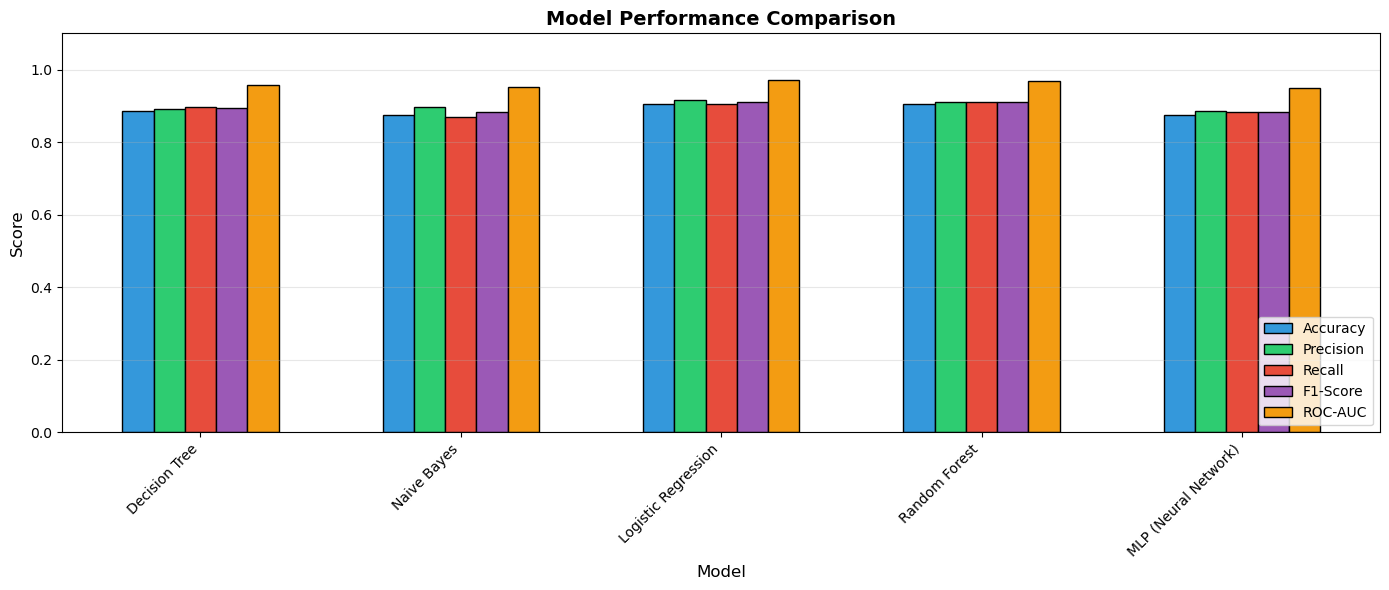

In [18]:
# =============================================================================
# 11. RESULTS VISUALIZATION
# =============================================================================
print("\n[11] Visualizing Results...")

# ROC Curves
plt.figure(figsize=(10, 8))
colors = plt.cm.Set1(np.linspace(0, 1, len(results)))

for (name, result), color in zip(results.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_fixed.png', dpi=150, bbox_inches='tight')
plt.show()

# Confusion Matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    cm = result['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
               xticklabels=['Pred 0', 'Pred 1'],
               yticklabels=['Actual 0', 'Actual 1'])
    axes[idx].set_title(f'{name}', fontweight='bold')

plt.suptitle('Confusion Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrices_fixed.png', dpi=150, bbox_inches='tight')
plt.show()

# Performance comparison table
metrics_df = pd.DataFrame({name: result['metrics'] for name, result in results.items()}).T
metrics_df = metrics_df.round(4)

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(metrics_df.to_string())

# Save to CSV
metrics_df.to_csv('model_comparison_fixed.csv')
print("\n✓ Results saved to 'model_comparison_fixed.csv'")

# Metrics comparison chart
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(results))
width = 0.12
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']

for i, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    values = [results[name]['metrics'][metric] for name in results.keys()]
    ax.bar(x + i*width, values, width, label=metric, color=color, edgecolor='black')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(results.keys(), rotation=45, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0, 1.1)
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('metrics_comparison_fixed.png', dpi=150, bbox_inches='tight')
plt.show()

In [19]:
# =============================================================================
# 12. BEST MODEL SELECTION
# =============================================================================
print("\n[12] Selecting Best Model...")
print("="*70)

best_model_name = metrics_df['F1-Score'].idxmax()
best_f1 = metrics_df.loc[best_model_name, 'F1-Score']
best_auc = metrics_df.loc[best_model_name, 'ROC-AUC']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   ROC-AUC: {best_auc:.4f}")
print(f"   Accuracy: {metrics_df.loc[best_model_name, 'Accuracy']:.4f}")

print("\nModel Rankings by F1-Score:")
for i, (name, score) in enumerate(metrics_df['F1-Score'].sort_values(ascending=False).items(), 1):
    print(f"  {i}. {name}: {score:.4f}")

print("\n" + "="*70)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("="*70)
print("\nGenerated files:")
print("  - target_distribution_fixed.png")
print("  - roc_curves_fixed.png")
print("  - confusion_matrices_fixed.png")
print("  - metrics_comparison_fixed.png")
print("  - model_comparison_fixed.csv")


[12] Selecting Best Model...

🏆 BEST MODEL: Random Forest
   F1-Score: 0.9117
   ROC-AUC: 0.9699
   Accuracy: 0.9050

Model Rankings by F1-Score:
  1. Random Forest: 0.9117
  2. Logistic Regression: 0.9105
  3. Decision Tree: 0.8947
  4. MLP (Neural Network): 0.8845
  5. Naive Bayes: 0.8826

PIPELINE COMPLETED SUCCESSFULLY!

Generated files:
  - target_distribution_fixed.png
  - roc_curves_fixed.png
  - confusion_matrices_fixed.png
  - metrics_comparison_fixed.png
  - model_comparison_fixed.csv
